## Pre-processing



### Importing the data 



In [1]:
import nltk
import gensim
import pandas as pd

# Read the data from the file
data_garmin_df = pd.read_csv('data/Garmin_Connect.csv')
data_samsung_df = pd.read_csv('data/Samsung_Health.csv')
data_huawei_df = pd.read_csv('data/Huawei_Health.csv')

data = pd.concat([data_garmin_df, data_samsung_df, data_huawei_df], ignore_index=True)
#data.to_csv('data/concatenated_data.csv', sep='\t', encoding='utf-8')

print(data.head(10))
print("\n Number of rows: " + str(len(data)))



                                                data  score  rating  \
0  Contrairement aux idées reçues le traceur GPS ...      5       1   
1               Application très pratique et fiable.      5       1   
2                                   jadore ma montre      5       1   
3  Super application, je l'utilise synchronisé av...      5       1   
4                                            Super !      5       1   
5  Application très pratique et très simple d'uti...      3       1   
6  Suivis du sommeil cardio nombre de pas avec la...      5       1   
7                                  Sympa et précis !      5       1   
8                                     Très satisfait      5       1   
9  bonjour, le calendrier ne se synchronise plus....      2       0   

   bug_report  feature_request  user_experience  
0           0                0                1  
1           0                0                0  
2           0                0                0  
3           0     

### Tokenization and removal of stopwords

*Tokenization* is the process of splitting an input text into tokens (words or other relevant elements, such as punctuation, empty strings). We will use the result as a basis to predict a label.


In [2]:
from nltk.tokenize import word_tokenize #principal tokenization class from nltk API
from nltk.stem import SnowballStemmer   #Stemming method
import re                               #regex library
nltk.download('punkt')
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('french') + stopwords.words('english')
## IMPLEMENT LEMMATIZATION

corpus = []

for index, row in data.iterrows():
    review = re.sub('\*', '', row["data"]) # get data, substitute asterisks for empty string, put into review
    review = re.sub('[^a-zA-Z]', ' ', review) # from review, remove all non-alphabetic characters
    review = re.sub('[^\w\s]', '', review) # remove punctuation from review
    review = ' '.join([SnowballStemmer('french').stem(w) for w in word_tokenize(review.lower(), language='french')]) # apply stemming
    corpus.append(review)

#print(corpus)

data = data.assign(token=corpus)

print(data.head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\radio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                data  score  rating  \
0  Contrairement aux idées reçues le traceur GPS ...      5       1   
1               Application très pratique et fiable.      5       1   
2                                   jadore ma montre      5       1   
3  Super application, je l'utilise synchronisé av...      5       1   
4                                            Super !      5       1   

   bug_report  feature_request  user_experience  \
0           0                0                1   
1           0                0                0   
2           0                0                0   
3           0                0                1   
4           0                0                0   

                                               token  
0  contrair aux id e re ue le traceur gp est tr s...  
1                      appliqu tr s pratiqu et fiabl  
2                                     jador ma montr  
3  sup appliqu je l utilis synchron avec ma fe

### Separation between train and test datasets

Separate in adequate proportions to avoid the overfitting of the modules the data between features and targets. In this case there will be 2 different separations, one for the original multilabel problem and another for the mold into just a multiclass problem. To ensure a more even tag distribution, we must use the *stratify* hyper-parameter

In [37]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
x_stemmed_lemmatized = data['token']  # try to include / exclude score and check if it yields better results
data['text_clean'] = data['data'].apply(lambda x: gensim.utils.simple_preprocess(x))
# remove stopwords
data['text_clean'] = data['text_clean'].apply(lambda x: [item for item in x if item not in final_stopwords_list])
x_basic_preprocessing = data['text_clean']

y = data[['rating', 'bug_report', 'feature_request', 'user_experience']]

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(x_stemmed_lemmatized, y, stratify=y, test_size=0.2, random_state=42)

X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(x_basic_preprocessing, y, stratify=y, test_size=0.2, random_state=42)



0    [contrairement, idées, reçues, traceur, gps, t...
1                [application, très, pratique, fiable]
2                                     [jadore, montre]
3    [super, application, utilise, synchronisé, fen...
4                                              [super]
Name: text_clean, dtype: object


# Approaches to multilabel classification we will consider:

#### Problem transformation
1. Binary Relevance (consider each label as a separate single class classification  problem)
2. Classifier Chains
3. Label powerset

#### Adapted Algorithms

#### Ensemble methods

#### Sparse Representation: Finding the best parameters for TF-IDF Transformer and CountVectorizer

These two preprocessing steps will be present in all of our sparse pipelines, so lets check what hyperparameters are best for them

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
nltk.download('stopwords')

# Define the hyperparameters to tune for the TfidfTransformer, which will be the same for every method approach as this preprocessor is always used
tfidf_params = {
    'use_idf': [True, False],
    'smooth_idf': [True, False],
    'sublinear_tf': [True, False],
    'norm': ['l1', 'l2']
}

#Define the hyperparameters to tune for the CountVectorizer, which will be the same for every method approach as this preprocessor is always used
count_vectorizer_params = {
    'max_df': [0.5, 0.75, 1.0],
    'min_df': [0.2, 0.25, 0.3],
    'max_features': [None, 10000, 20000],
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'stop_words': [None, final_stopwords_list],
}

grid_params = {
        'vect__max_df': count_vectorizer_params['max_df'],
        'vect__ngram_range': count_vectorizer_params['ngram_range'],
        'vect__min_df': count_vectorizer_params['min_df'],
        'vect__stop_words': count_vectorizer_params['stop_words'],
        'tfidf__use_idf': tfidf_params['use_idf'],
        'tfidf__smooth_idf': tfidf_params['smooth_idf'],
        'tfidf__sublinear_tf': tfidf_params['sublinear_tf'],
        'tfidf__norm': tfidf_params['norm'],
        
}


# Create the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

# Create the grid search
grid_search = GridSearchCV(pipeline, grid_params, cv=2, n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train_tfidf, y_train_tfidf)

# Print the best parameters
print("Best parameters:" , grid_search.best_params_)
print("Best score: ", grid_search.best_score_)



### Best parameters for count_vectorizer and tf_idf_transformer
So we don't have to run the gridSearch multiple times 

Best parameters: 
- 'tfidf__norm': 'l1'
- 'tfidf__smooth_idf': True
- 'tfidf__sublinear_tf': True
- 'tfidf__use_idf': True
- 'vect__max_df': 0.8
- 'vect__min_df': 0.2
- 'vect__ngram_range': (1, 2)
- 'vect__stop_words': final_stopwords_list



In [28]:
# create a new count vectorizer with the best parameters

final_stopwords_list = stopwords.words('french') + stopwords.words('english')

count_vectorizer = CountVectorizer(
    max_df=0.8,
    ngram_range=(1, 1),
    #min_df=0.2,
    stop_words=final_stopwords_list,
)

tf_idf_transformer = TfidfTransformer(
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False,
    norm='l1',
)
X = count_vectorizer.fit_transform(X_train).toarray()
print(X_train[0])
print(X[0])

Contrairement aux idées reçues le traceur GPS est très précis, dumoins avec vivoactive 3 Music.. Très motivant pour la suite. Je conseil garmin
[0 0 0 ... 0 0 0]


### Dense representation: Word Embeddings

In [29]:

# Word2Vec model trained on the corpus

w2v_model = gensim.models.Word2Vec(X_train_basic,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

We can use our trained Word2Vec model to find similarities between words. Let's find the most similar words for 'compatibilité' to make sure it is working

In [18]:
# Find the most similar words to "compatibilité" based on word vectors from our trained model
w2v_model.wv.most_similar('compatibilité')

[('course', 0.9959745407104492),
 ('entrainement', 0.9959266781806946),
 ('fait', 0.9959033727645874),
 ('fais', 0.9958943724632263),
 ('petit', 0.9958926439285278),
 ('parcours', 0.9958776235580444),
 ('si', 0.995867133140564),
 ('exercice', 0.995858907699585),
 ('activité', 0.9958510398864746),
 ('pense', 0.9958379864692688)]

### Generate aggregated sentence vectors based on the word vectors for each word in the sentences

In [30]:
import numpy as np
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_basic])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_basic])

C:\Users\radio\AppData\Local\Temp\ipykernel_1028\3368788182.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\radio\AppData\Local\Temp\ipykernel_1028\3368788182.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


### Problem: inconsistent number of features in each sentence

In [ ]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    print(len(X_train_basic.iloc[i]), len(v))

If we were to pass these values into a machine learning algorithm, it would throw an error, because of the inconsistent amount of features in each data entry. In order to combat this, we are going to take an element wise average: We saw that there are two word vectors for the first sentence. Each of those word vectors is of size 100 because that’s the way we set it when we trained our model. What we’re going to do is we’re going to average the first element across those four word vectors and store that as the first entry in our final vector. Then we’ll do the same thing for the second element, and for the third, and so on. What we’ll end up with is now a single vector of length 100 that represents each text by averaging those word vectors for the words that were represented in that text message.

In [32]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

Checking that our sentence word vectors are of consistent 100 length:

In [ ]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train_basic.iloc[i]), len(v))

## Pipeline

Our approach to the machine learning pipeline is as follows: create a function that creates pipelines taking in the estimators we pass to it(this is how we'll implement the many approaches to multilabel classification) and choosing whether we want to use TF-IDF or Word2Vec model for the pre-processing step.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics


def make_pipeline(clf_param_grid, clf,pre_processing='tf_idf'):
    pipeline = None
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    if pre_processing == 'tf_idf':
        X_train = X_train_tfidf
        y_train = y_train_tfidf
        X_test = X_test_tfidf
        y_test = y_test_tfidf
        pipeline = Pipeline([
            ('vect', count_vectorizer),
            ('tfidf', tf_idf_transformer),
            ('clf', clf)
        ])
    elif pre_processing == 'word2vec':
        X_train = X_train_vect_avg
        y_train = y_train_basic
        X_test = X_test_vect_avg
        y_test = y_test_basic
       
        pipeline = Pipeline([
            ('clf', clf)
        ])

    # Define the GridSearchCV object to tune the hyperparameters
    grid_params = [
        {
        **clf_param
        }
        for clf_param in clf_param_grid
    ]

    # Define the GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid=grid_params, cv=2, n_jobs=-1)


    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    print("Best parameters: ", best_params)
    

    # Evaluate the best model on the test data
    y_pred = best_model.predict(X_test)
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print(y_pred.count_nonzero())
    #Apply classification report
    print(metrics.classification_report(y_test, y_pred, digits=3, target_names=['rating', 'bug_report', 'feature_request', 'user_experience']))



# Adaptive algorithms


In [31]:
# using binary relevance
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = DecisionTreeClassifier() # what is this?

param_grid_adaptive_algorithms = [
    #{
    #    'clf': [DecisionTreeClassifier()],
    #    'clf__criterion': ["gini", "entropy", "log_loss"],
    #    'clf__min_samples_split': [1, 2, 10, 20],
    #    'clf__max_depth': [None, 1, 2, 5, 10, 20, 50, 100],
    #    'clf__class_weight': [None, 'balanced'],
    #    'clf__random_state': [None, 42],
    #    'clf__max_features': [None, 'auto', 'sqrt', 'log2'],
    #},
    {
        'clf': [ExtraTreeClassifier()],
        'clf__criterion': ["gini", "entropy", "log_loss"],
        'clf__min_samples_split': [1, 2, 10, 20],
        'clf__max_depth': [None, 1, 10, 20, 100],
        'clf__class_weight': [None, 'balanced'],
        'clf__random_state': [None, 42],
        'clf__max_features': [None, 'auto', 'sqrt', 'log2'],
    },
    #{
    #    'clf': [KNeighborsClassifier()],
    #    'clf__n_neighbors': [1, 2, 5, 10, 20, 50, 100],
    #    'clf__weights': ['uniform', 'distance'],
    #   'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #   'clf__metric': ['minkowski', 'euclidean', 'manhattan'],
    #   'clf__p': [1, 2, 3, 4, 5],        
    #},
    #{
    #    'clf': [RidgeClassifier()],
    #    'clf__alpha': [0.1, 5.0, 10.0],
    #    'clf__fit_intercept': [True, False],
    #    'clf__class_weight': [None, 'balanced'],
    #    'clf__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    #    'clf__random_state': [None, 42]
    #}  
]

make_pipeline(param_grid_adaptive_algorithms, clf)

Best parameters:  {'clf': ExtraTreeClassifier(criterion='entropy', max_features=None, min_samples_split=1,
                    random_state=42), 'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_split': 1, 'clf__random_state': 42}
Best model:  Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['au', 'aux', 'avec', 'ce', 'ces',
                                             'dans', 'de', 'des', 'du', 'elle',
                                             'en', 'et', 'eux', 'il', 'ils',
                                             'je', 'la', 'le', 'les', 'leur',
                                             'lui', 'ma', 'mais', 'me', 'même',
                                             'mes', 'moi', 'mon', 'ne', 'nos', ...])),
                ('tfidf', TfidfTransformer(norm='l1')),
                ('clf',
                 ExtraTreeClassifier(criterion='entropy', max_features=None,
                  

## Problem transformation: Binary Relevance

In [41]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

clf = BinaryRelevance(GaussianNB())

param_grid_binary_relevance = [
    {
        'clf': [clf],
        'clf__classifier__var_smoothing': [1e-9, 1e-8]
    },
    {
        'clf': [BinaryRelevance(RandomForestClassifier(), require_dense=[False, True])],
        'clf__classifier__n_estimators': [200, 250, 300],
        'clf__classifier__max_depth': [10, 20],
    },
    #{
    #    'clf': [BinaryRelevance(LinearSVC(), require_dense=[False, True])],
    #    'clf__classifier__penalty': ['l2'],
    #    'clf__classifier__C': [0.1, 1, 10],
    

    #}
    #{
    #    'clf': [BinaryRelevance(LogisticRegression())],
    #    'clf__classifier__penalty': ['l1', 'l2'],
    #    'clf__classifier__C': [0.1, 1, 10],
    #    'clf__classifier__solver': ['liblinear', 'saga']
    #}
]

make_pipeline(param_grid_binary_relevance, clf, pre_processing='word2vec')

### Problem adaptation : Classifier Chains

Classifier Chains is a machine learning technique used in multi-label classification problems where each instance or example can have multiple labels or classes. In this approach, multiple binary classifiers are created, where each classifier predicts the presence or absence of one label or class. The prediction of one classifier is then used as an input feature for the next classifier in the chain, creating a chain of classifiers.
The best results were obtain with SVC.
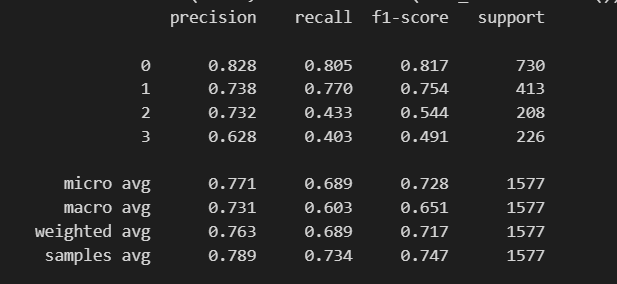

In [61]:
# using binary relevance
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf = ClassifierChain(SVC())

param_grid_classifier_chains = [
    {
        'clf': [ClassifierChain( SVC())],
    },
    {
        'clf': [ClassifierChain( MultinomialNB())],
    },
    {
        'clf': [ClassifierChain( LogisticRegression())],
    },

]

make_pipeline(param_grid_classifier_chains, clf, Pre_processing='word2vec')

TypeError: make_pipeline() got an unexpected keyword argument 'Pre_processing'